In [3]:
# ---------------------------------
# 步骤 1：导入库并挂载 Drive
# ---------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import json
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
# from google.colab import drive

# try:
#     drive.mount('/content/gdrive')
# except Exception as e:
#     print(f"Google Drive 挂载失败: {e}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


#### 工具函数

In [4]:
# ---------------------------------
# 步骤 2：定义 V16 的所有 CoM 模块
# (与 V15 脚本中的定义完全相同)
# ---------------------------------

class DifferentiableCoM_Patch_3x5(nn.Module):
    """(子模块) 在 3x5 色块局部坐标系中计算 (x, y) [0-4, 0-2]"""
    def __init__(self, height=3, width=5):
        super(DifferentiableCoM_Patch_3x5, self).__init__()
        self.height, self.width = height, width
        y, x = torch.linspace(0, height - 1, height), torch.linspace(0, width - 1, width)
        x_grid, y_grid = x.view(1, -1).repeat(height, 1), y.view(-1, 1).repeat(1, width)
        self.register_buffer('x_grid_buf', x_grid)
        self.register_buffer('y_grid_buf', y_grid)
    def forward(self, image):
        img = image.squeeze(1); eps = 1e-8
        mass = torch.sum(img, dim=(1, 2)) + eps
        x_weighted = torch.sum(img * self.x_grid_buf, dim=(1, 2))
        y_weighted = torch.sum(img * self.y_grid_buf, dim=(1, 2))
        center_x, center_y = x_weighted / mass, y_weighted / mass
        return torch.stack([center_x, center_y], dim=1)

class CoM_from_Patch_V12(nn.Module):
    """
    (V16 Pred 管线)
    (3x5 色块, 10-col 峰值, 奇偶标记) -> 18-col 全局坐标
    """
    def __init__(self, patch_h=3, patch_w=5):
        super(CoM_from_Patch_V12, self).__init__()
        self.local_com_calc = DifferentiableCoM_Patch_3x5(patch_h, patch_w)
        self.ph_offset = patch_h // 2
        self.pw_offset_10col = patch_w // 2
        odd_grid_10_np = np.array([0.5, 2.5, 4.5, 6.5, 8.0, 9.0, 10.5, 12.5, 14.5, 16.5], dtype=np.float32)
        even_grid_10_np = np.array([0.0, 1.5, 3.5, 5.5, 7.5, 9.5, 11.5, 13.5, 15.5, 17.0], dtype=np.float32)
        self.register_buffer('odd_grid_10', torch.from_numpy(odd_grid_10_np))
        self.register_buffer('even_grid_10', torch.from_numpy(even_grid_10_np))
    def forward(self, patches, is_odd_flags, peak_rs, peak_cs_10_col):
        local_coords_3x5 = self.local_com_calc(patches)
        local_x_10col_scalar = local_coords_3x5[:, 0]
        local_y_scalar = local_coords_3x5[:, 1]
        global_x_10col_scalar = local_x_10col_scalar + peak_cs_10_col - self.pw_offset_10col
        global_y_scalar = local_y_scalar + peak_rs - self.ph_offset
        x_clamped = torch.clamp(global_x_10col_scalar, 0, 9)
        x_floor, x_ceil = torch.floor(x_clamped).long(), torch.ceil(x_clamped).long()
        x_floor, x_ceil = torch.clamp(x_floor, 0, 9), torch.clamp(x_ceil, 0, 9)
        frac = x_clamped - x_floor.float()
        grids = torch.stack([self.even_grid_10, self.odd_grid_10], dim=0)
        selected_grids = grids[is_odd_flags.long()]
        val_floor = torch.gather(selected_grids, 1, x_floor.unsqueeze(-1)).squeeze(-1)
        val_ceil = torch.gather(selected_grids, 1, x_ceil.unsqueeze(-1)).squeeze(-1)
        global_x_18col_scalar = val_floor + (val_ceil - val_floor) * frac
        return torch.stack([global_x_18col_scalar, global_y_scalar], dim=1)

class CoM_from_18col_Patch_V15(nn.Module):
    """
    (V16 GT 管线)
    (3x5 色块, 18-col 峰值) -> 18-col 全局坐标
    """
    def __init__(self, patch_h=3, patch_w=5):
        super(CoM_from_18col_Patch_V15, self).__init__()
        self.local_com_calc = DifferentiableCoM_Patch_3x5(patch_h, patch_w)
        self.ph_offset = patch_h // 2
        self.pw_offset_18col = patch_w // 2
    def forward(self, patches, peak_rs, peak_cs_18_col):
        local_coords_3x5 = self.local_com_calc(patches)
        local_x_scalar = local_coords_3x5[:, 0]
        local_y_scalar = local_coords_3x5[:, 1]
        global_x_18col_scalar = local_x_scalar + peak_cs_18_col - self.pw_offset_18col
        global_y_scalar = local_y_scalar + peak_rs - self.ph_offset
        return torch.stack([global_x_18col_scalar, global_y_scalar], dim=1)

#### 模型定义

In [5]:
# ---------------------------------
# 步骤 3：定义 V16 的模型 (Teacher 和 Student)
# (与 V15 脚本中的定义完全相同)
# ---------------------------------

# --- V16 "教师" 模型 (V13 架构) ---
class _PatchNet_V13_Large_Teacher(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 8, 3, padding=1, bias=False), nn.BatchNorm2d(8), nn.ReLU(inplace=True),
            nn.Conv2d(8, 16, 3, padding=1, bias=False), nn.BatchNorm2d(16), nn.ReLU(inplace=True),
            nn.Conv2d(16, 8, 1, bias=False), nn.BatchNorm2d(8), nn.ReLU(inplace=True),
            nn.Conv2d(8, out_channels, 1)
        )
    def forward(self, x): return self.net(x)

class TeacherModel(nn.Module):
    def __init__(self):
        super(TeacherModel, self).__init__()
        self.odd_net = _PatchNet_V13_Large_Teacher()
        self.even_net = _PatchNet_V13_Large_Teacher()
    def forward(self, x_patches, is_odd_flags):
        out_odd = self.odd_net(x_patches)
        out_even = self.even_net(x_patches)
        is_odd_mask = is_odd_flags.view(-1, 1, 1, 1) > 0.5
        out = torch.where(is_odd_mask, out_odd, out_even)
        return torch.relu(out)

# --- V16 "学生" 模型 (V14 架构) ---
class _PatchNet_V14_Student(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 2, 3, padding=1, bias=False), nn.BatchNorm2d(2), nn.ReLU(inplace=True),
            nn.Conv2d(2, 4, 3, padding=1, bias=False), nn.BatchNorm2d(4), nn.ReLU(inplace=True),
            nn.Conv2d(4, 2, 1, bias=False), nn.BatchNorm2d(2), nn.ReLU(inplace=True),
            nn.Conv2d(2, out_channels, 1)
        )
    def forward(self, x): return self.net(x)

class StudentModel(nn.Module):
    def __init__(self):
        super(StudentModel, self).__init__()
        self.odd_net = _PatchNet_V14_Student()
        self.even_net = _PatchNet_V14_Student()
    def forward(self, x_patches, is_odd_flags):
        out_odd = self.odd_net(x_patches)
        out_even = self.even_net(x_patches)
        is_odd_mask = is_odd_flags.view(-1, 1, 1, 1) > 0.5
        out = torch.where(is_odd_mask, out_odd, out_even)
        return torch.relu(out)

In [6]:
class SensorDataset_V16_Final(Dataset):
    def __init__(self, data_dir, patch_size, device):
        self.device = device
        self.patch_h, self.patch_w = patch_size
        print(f"Pre-processing JSON data from: {data_dir} (V16 Pipeline)")

        self.odd_pairs  = [(0,1),(2,3),(4,5),(6,7),(10,11),(12,13),(14,15),(16,17)]
        self.odd_single = [(8,4), (9,5)]; self.odd_map_18_to_10 = {0:0, 1:0, 2:1, 3:1, 4:2, 5:2, 6:3, 7:3, 8:4, 9:5, 10:6, 11:6, 12:7, 13:7, 14:8, 15:8, 16:9, 17:9}
        self.even_pairs = [(1,2),(3,4),(5,6),(7,8),(9,10),(11,12),(13,14),(15,16)]
        self.even_single= [(0,0), (17,9)]; self.even_map_18_to_10 = {0:0, 1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:4, 8:4, 9:5, 10:5, 11:6, 12:6, 13:7, 14:7, 15:8, 16:8, 17:9}

        samples_cpu = self._load_and_process_patches(data_dir)

        if not samples_cpu: print("错误: 未加载任何样本"); self.n_samples = 0; return

        print("Stacking and moving all patches to GPU...")
        self.raw_patches_gpu = torch.stack([s["raw_patch"] for s in samples_cpu]).unsqueeze(1).to(device)
        self.clean_patches_gpu = torch.stack([s["clean_patch"] for s in samples_cpu]).unsqueeze(1).to(device)
        self.is_odd_gpu = torch.tensor([s["is_odd"] for s in samples_cpu], dtype=torch.float32).to(device)

        # GT 管线锚点 (来自 18-col 干净数据)
        peak_r_gt_list = [s["peak_r_gt"] for s in samples_cpu]
        peak_c_18_gt_list = [s["peak_c_gt_18"] for s in samples_cpu]
        peak_coords_18_gt_cpu = np.stack([peak_r_gt_list, peak_c_18_gt_list], axis=1).astype(np.float32)
        self.peak_coords_18_gt_gpu = torch.from_numpy(peak_coords_18_gt_cpu).to(device)

        # Pred 管线锚点 (来自 10-col 短接数据)
        peak_r_m_list = [s["peak_r_m"] for s in samples_cpu]
        peak_c_10_m_list = [s["peak_c_m_10"] for s in samples_cpu]
        peak_coords_10_m_cpu = np.stack([peak_r_m_list, peak_c_10_m_list], axis=1).astype(np.float32)
        self.peak_coords_10_m_gpu = torch.from_numpy(peak_coords_10_m_cpu).to(device)

        self.n_samples = len(self.raw_patches_gpu)
        print(f"Dataset pre-processing complete. Found {self.n_samples} samples (on GPU).")

    def _compress_to_10_col(self, matrix_18_col):
        matrix_10_col = np.zeros((32, 10), dtype=np.float32)
        for r in range(32):
            is_odd = (r % 2 == 1)
            pairs = self.odd_pairs if is_odd else self.even_pairs
            singles = self.odd_single if is_odd else self.even_single
            map_18_to_10 = self.odd_map_18_to_10 if is_odd else self.even_map_18_to_10
            for (c_left, c_right) in pairs:
                col_10_idx = map_18_to_10[c_left]; avg = (matrix_18_col[r, c_left] + matrix_18_col[r, c_right]) / 2.0; matrix_10_col[r, col_10_idx] = avg
            for (c_18, col_10_idx) in singles: matrix_10_col[r, col_10_idx] = matrix_18_col[r, c_18]
        return matrix_10_col

    def _load_and_process_patches(self, data_dir):
        samples_in_memory = []; all_files = sorted([f for f in os.listdir(data_dir) if f.lower().endswith('.json')])
        print(f"找到 {len(all_files)} 个 JSON 文件。正在预处理..."); ph, pw = self.patch_h // 2, self.patch_w // 2
        pad2d_18_col = (pw, pw, ph, ph); pad2d_10_col = (pw, pw, ph, ph); eps = 1e-8

        for filename in tqdm(all_files, desc="Pre-processing JSONs"):
            filepath = os.path.join(data_dir, filename)
            try:
                with open(filepath, 'r', encoding='utf-8') as f: aligned_data = json.load(f)
                for point_id, pair_data in aligned_data.items():
                    merging_18 = np.array(pair_data['merging']['normalized_matrix'], dtype=np.float32)
                    target_18 = np.array(pair_data['nonmerging']['normalized_matrix'], dtype=np.float32)
                    if merging_18.shape != (32, 18): continue

                    # --- V16 管线 1：GT (nonmerging) ---
                    peak_r_gt, peak_c_gt_18 = np.unravel_index(np.argmax(target_18), (32, 18))
                    target_t_18 = F.pad(torch.from_numpy(target_18), pad2d_18_col)
                    r0_t, r1_t = peak_r_gt, peak_r_gt + self.patch_h
                    c0_t, c1_t = peak_c_gt_18, peak_c_gt_18 + self.patch_w
                    clean_patch = target_t_18[r0_t:r1_t, c0_t:c1_t] # [3, 5]

                    # --- V16 管线 2：Input (merging) ---
                    effective_merging_10 = self._compress_to_10_col(merging_18)
                    peak_r_m, peak_c_m_10 = np.unravel_index(np.argmax(effective_merging_10), (32, 10))
                    is_odd = float(peak_r_m % 2 == 1) # 锚点来自 merging, is_odd 也来自 merging

                    merging_t_10 = F.pad(torch.from_numpy(effective_merging_10), pad2d_10_col)
                    r0_m, r1_m = peak_r_m, peak_r_m + self.patch_h
                    c0_m, c1_m = peak_c_m_10, peak_c_m_10 + self.patch_w
                    merging_patch = merging_t_10[r0_m:r1_m, c0_m:c1_m] # [3, 5]

                    # 3. 归一化 (两个色块都归一化)
                    merging_patch = merging_patch.clamp_min(0); merging_patch = merging_patch / (merging_patch.sum() + eps)
                    clean_patch = clean_patch.clamp_min(0); clean_patch = clean_patch / (clean_patch.sum() + eps)

                    samples_in_memory.append({
                        "raw_patch": merging_patch,       # [3, 5]
                        "clean_patch": clean_patch,     # [3, 5]
                        "is_odd": is_odd,
                        "peak_r_gt": peak_r_gt,         # 锚点 1 (GT)
                        "peak_c_gt_18": peak_c_gt_18,   # 锚点 1 (GT)
                        "peak_r_m": peak_r_m,           # 锚点 2 (Pred)
                        "peak_c_m_10": peak_c_m_10,     # 锚点 2 (Pred)
                    })
            except Exception as e: print(f"警告: 跳过文件 {filename} (错误: {e})")
        return samples_in_memory

    def __len__(self): return self.n_samples
    def __getitem__(self, idx):
        return (
            self.raw_patches_gpu[idx],
            self.clean_patches_gpu[idx],
            self.is_odd_gpu[idx],
            self.peak_coords_18_gt_gpu[idx][0],     # peak_r_gt
            self.peak_coords_18_gt_gpu[idx][1],     # peak_c_gt_18
            self.peak_coords_10_m_gpu[idx][0],      # peak_r_m
            self.peak_coords_10_m_gpu[idx][1]       # peak_c_m_10
        )

#### 训练函数

In [7]:
# --- V16-Teacher 训练函数 ---
def train_teacher_epoch(model, loader, optimizer, scheduler):
    model.train()
    total_loss, total_coords_loss = 0, 0
    for raw_patch, clean_patch, is_odd, peak_r_gt, peak_c_gt_18, peak_r_m, peak_c_m_10 in loader:

        # --- Pred 管线 (V16) ---
        pred_decoupled_patch = model(raw_patch, is_odd)
        pred_global_coords = com_calc_from_10col_patch(pred_decoupled_patch, is_odd, peak_r_m, peak_c_m_10)

        # --- GT 管线 (V15) ---
        with torch.no_grad():
            target_global_coords = com_calc_from_18col_patch(clean_patch, peak_r_gt, peak_c_gt_18)

        loss_coords = mse_loss_fn(pred_global_coords, target_global_coords)
        total_loss_batch = loss_coords

        optimizer.zero_grad(); total_loss_batch.backward(); optimizer.step()
        total_loss += total_loss_batch.item(); total_coords_loss += loss_coords.item()

    num_batches = max(1, len(loader)); scheduler.step(total_coords_loss / num_batches)
    return total_loss / num_batches, total_coords_loss / num_batches

def validate_teacher_epoch(model, loader):
    model.eval()
    total_loss, total_coords_loss = 0, 0
    with torch.no_grad():
        for raw_patch, clean_patch, is_odd, peak_r_gt, peak_c_gt_18, peak_r_m, peak_c_m_10 in loader:
            pred_decoupled_patch = model(raw_patch, is_odd)
            pred_global_coords = com_calc_from_10col_patch(pred_decoupled_patch, is_odd, peak_r_m, peak_c_m_10)
            target_global_coords = com_calc_from_18col_patch(clean_patch, peak_r_gt, peak_c_gt_18)
            loss_coords = mse_loss_fn(pred_global_coords, target_global_coords)
            total_loss_batch = loss_coords
            total_loss += total_loss_batch.item(); total_coords_loss += loss_coords.item()
    num_batches = max(1, len(loader))
    return total_loss / num_batches, total_coords_loss / num_batches

# --- V16-Student (Distill) 训练函数 ---
def train_student_epoch(student_model, teacher_model, loader, optimizer, scheduler):
    student_model.train()
    total_loss, total_coords_loss, total_distill_loss = 0, 0, 0
    for raw_patch, clean_patch, is_odd, peak_r_gt, peak_c_gt_18, peak_r_m, peak_c_m_10 in loader:

        with torch.no_grad():
            pred_patch_teacher = teacher_model(raw_patch, is_odd)

        pred_patch_student = student_model(raw_patch, is_odd)
        pred_global_coords_student = com_calc_from_10col_patch(pred_patch_student, is_odd, peak_r_m, peak_c_m_10)

        with torch.no_grad():
            target_global_coords = com_calc_from_18col_patch(clean_patch, peak_r_gt, peak_c_gt_18)

        loss_coords = mse_loss_fn(pred_global_coords_student, target_global_coords)
        loss_distill = mse_loss_fn(pred_patch_student, pred_patch_teacher)
        total_loss_batch = (ALPHA * loss_coords) + ((1.0 - ALPHA) * loss_distill)

        optimizer.zero_grad(); total_loss_batch.backward(); optimizer.step()
        total_loss += total_loss_batch.item(); total_coords_loss += loss_coords.item(); total_distill_loss += loss_distill.item()

    num_batches = max(1, len(loader)); scheduler.step(total_coords_loss / num_batches)
    return total_loss / num_batches, total_coords_loss / num_batches, total_distill_loss / num_batches

def validate_student_epoch(student_model, teacher_model, loader):
    student_model.eval()
    total_loss, total_coords_loss, total_distill_loss = 0, 0, 0
    with torch.no_grad():
        for raw_patch, clean_patch, is_odd, peak_r_gt, peak_c_gt_18, peak_r_m, peak_c_m_10 in loader:
            pred_patch_teacher = teacher_model(raw_patch, is_odd)
            pred_patch_student = student_model(raw_patch, is_odd)
            pred_global_coords_student = com_calc_from_10col_patch(pred_patch_student, is_odd, peak_r_m, peak_c_m_10)
            target_global_coords = com_calc_from_18col_patch(clean_patch, peak_r_gt, peak_c_gt_18)
            loss_coords = mse_loss_fn(pred_global_coords_student, target_global_coords)
            loss_distill = mse_loss_fn(pred_patch_student, pred_patch_teacher)
            total_loss_batch = (ALPHA * loss_coords) + ((1.0 - ALPHA) * loss_distill)
            total_loss += total_loss_batch.item(); total_coords_loss += loss_coords.item(); total_distill_loss += loss_distill.item()
    num_batches = max(1, len(loader))
    return total_loss / num_batches, total_coords_loss / num_batches, total_distill_loss / num_batches

#### 实例化

In [8]:
# --- 实例化 V16 Dataset 和 DataLoader ---
JSON_DATA_DIR = '/work/hwc/SPARSE/training_data/aligned_data_for_training_int'
PATCH_SIZE = (3, 5)

try:
    full_dataset = SensorDataset_V16_Final(JSON_DATA_DIR, patch_size=PATCH_SIZE, device=device)
    train_size = int(0.8 * len(full_dataset)); val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
    BATCH_SIZE = 64
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    print(f"\nData (V16 Pipeline) loaded successfully!")
    print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
except Exception as e:
    print(f"\n--- ⚠️ V16 数据加载失败! ⚠️ ---"); print(f"错误信息: {e}")

Pre-processing JSON data from: /work/hwc/SPARSE/training_data/aligned_data_for_training_int (V16 Pipeline)
找到 30 个 JSON 文件。正在预处理...


Pre-processing JSONs: 100%|██████████| 30/30 [00:01<00:00, 23.45it/s]


Stacking and moving all patches to GPU...
Dataset pre-processing complete. Found 2631 samples (on GPU).

Data (V16 Pipeline) loaded successfully!
Train samples: 2104, Val samples: 527


#### 训练

In [9]:

# ---------------------------------
# 步骤 5：定义 V16 训练循环
# ---------------------------------

NUM_EPOCHS = 100
TEACHER_MODEL_SAVE_PATH = '/work/hwc/SPARSE/distill/decoupler_model_v16_teacher_best.pth'
STUDENT_MODEL_SAVE_PATH = '/work/hwc/SPARSE/distill/pths/decoupler_model_v16_student_best.pth'

com_calc_from_10col_patch = CoM_from_Patch_V12(patch_h=3, patch_w=5).to(device) # (用于 Pred)
com_calc_from_18col_patch = CoM_from_18col_Patch_V15(patch_h=3, patch_w=5).to(device) # (用于 GT)
mse_loss_fn = nn.MSELoss()
ALPHA = 0.3 # 30% 硬目标 (真实坐标), 70% 软目标 (模仿教师色块)

In [ ]:
# --- ⚠️ V16 模式选择 ---
TRAIN_TEACHER = True
# -------------------------

NUM_EPOCHS = 100
TEACHER_MODEL_SAVE_PATH = '/work/hwc/SPARSE/distill/decoupler_model_v16_teacher_best.pth'
STUDENT_MODEL_SAVE_PATH = '/work/hwc/SPARSE/distill/pths/decoupler_model_v16_student_best.pth'
LEARNING_RATE = 0.0008

if 'train_loader' not in locals() or len(train_loader.dataset) == 0:
    print("训练未开始，因为数据加载失败。请检查 步骤 4 的路径。")
else:
    if TRAIN_TEACHER:
        print("--- 开始训练 (V16 - 教师模型) ---")
        model = TeacherModel().to(device)
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        best_val_coords_loss = float('inf')

        for epoch in range(NUM_EPOCHS):
            train_loss, train_coords = train_teacher_epoch(model, train_loader, optimizer, scheduler)
            val_loss, val_coords = validate_teacher_epoch(model, val_loader)
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch [{epoch+1:03d}/{NUM_EPOCHS:03d}] | (Teacher) | LR: {current_lr:.1e} | Val Loss: {val_loss:.4f} | Val Coords (Global): {val_coords:.4f}")
            if val_coords < best_val_coords_loss:
                best_val_coords_loss = val_coords
                torch.save(model.state_dict(), TEACHER_MODEL_SAVE_PATH)
                print(f"    -> 新的最佳教师模型已保存 (Val Coords: {val_coords:.4f})")
        print(f"--- 教师训练完成 ---")
        print(f"最佳教师模型 (Val Coords: {best_val_coords_loss:.4f}) 已保存至 {TEACHER_MODEL_SAVE_PATH}")

    else:
        print("--- 开始训练 (V16 - 学生模型/蒸馏) ---")
        teacher_model = TeacherModel().to(device)
        try:
            teacher_model.load_state_dict(torch.load(TEACHER_MODEL_SAVE_PATH, map_location=device))
            print(f"--- 成功加载 V16 教师模型 ---")
        except Exception as e:
            print(f"--- ⚠️ V16 教师模型加载失败! ⚠️ ---"); print(f"错误: {e}"); raise e
        teacher_model.eval()
        for param in teacher_model.parameters(): param.requires_grad = False
        model = StudentModel().to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        best_val_coords_loss = float('inf')

        for epoch in range(NUM_EPOCHS):
            train_loss, train_coords, train_distill = train_student_epoch(model, teacher_model, train_loader, optimizer, scheduler)
            val_loss, val_coords, val_distill = validate_student_epoch(model, teacher_model, val_loader)
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch [{epoch+1:03d}/{NUM_EPOCHS:03d}] | (Student) | LR: {current_lr:.1e} | Val Loss: {val_loss:.4f} | Val Coords (Hard): {val_coords:.4f} | Val Distill (Soft): {val_distill:.4f}")
            if val_coords < best_val_coords_loss:
                best_val_coords_loss = val_coords
                torch.save(model.state_dict(), STUDENT_MODEL_SAVE_PATH)
                print(f"    -> 新的最佳学生模型已保存 (Val Coords: {val_coords:.4f})")
        print(f"--- 学生训练完成 ---")
        print(f"最佳学生模型 (Val Coords: {best_val_coords_loss:.4f}) 已保存至 {STUDENT_MODEL_SAVE_PATH}")

#### 可视化

In [36]:
print("\n--- 开始可视化 (V16) ---")
# 批量可视化：遍历目录下所有 JSON 并将结果保存为 PNG（不再使用 plt.show()）
TEACHER_MODEL_SAVE_PATH = '/work/hwc/SPARSE/distill/selected_v16_teacher.pth'
VIZ_MODEL_PATH = STUDENT_MODEL_SAVE_PATH if not TRAIN_TEACHER else TEACHER_MODEL_SAVE_PATH
VIZ_MODEL_TYPE = "Student" if not TRAIN_TEACHER else "Teacher"
print(f"将加载最佳 {VIZ_MODEL_TYPE} 模型: {VIZ_MODEL_PATH}")

# 可更改的路径：要可视化的 JSON 目录 和 输出图片目录
JSON_DIR_FOR_VIZ = '/work/hwc/SPARSE/training_data/validation_int'
OUTPUT_DIR_FOR_VIZ = '/work/hwc/SPARSE/figs_val/v16_all'
VIZ_PATCH_SIZE = (3, 5)
os.makedirs(OUTPUT_DIR_FOR_VIZ, exist_ok=True)


def load_data_for_viz_v16(json_path, patch_size, device):
    """ 为可视化加载和处理 V16 兼容的数据，返回 (raw_tensor, clean_tensor, is_odd_tensor, peak_18_gt_tensor, peak_10_merging_tensor) 或 [None]*5 """
    raw_patch_list, clean_patch_list, is_odd_list = [], [], []
    peak_coords_18_gt_list, peak_coords_10_merging_list = [], []

    if not os.path.isfile(json_path):
        print(f"错误: 可视化文件未找到: {json_path}"); return [None]*5
    patch_h, patch_w = patch_size; ph, pw = patch_h // 2, patch_w // 2
    pad2d_18_col = (pw, pw, ph, ph); pad2d_10_col = (pw, pw, ph, ph); eps = 1e-8

    odd_pairs  = [(0,1),(2,3),(4,5),(6,7),(10,11),(12,13),(14,15),(16,17)]
    odd_map_18_to_10 = {0:0, 1:0, 2:1, 3:1, 4:2, 5:2, 6:3, 7:3, 8:4, 9:5, 10:6, 11:6, 12:7, 13:7, 14:8, 15:8, 16:9, 17:9}
    even_pairs = [(1,2),(3,4),(5,6),(7,8),(9,10),(11,12),(13,14),(15,16)]
    even_single= [(0,0), (17,9)]; even_map_18_to_10 = {0:0, 1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:4, 8:4, 9:5, 10:5, 11:6, 12:6, 13:7, 14:7, 15:8, 16:8, 17:9}

    def _compress_to_10_col_viz(matrix_18_col):
        matrix_10_col = np.zeros((32, 10), dtype=np.float32)
        for r in range(32):
            is_odd = (r % 2 == 1); pairs = odd_pairs if is_odd else even_pairs; singles = [(8,4), (9,5)] if is_odd else even_single
            map_18_to_10 = odd_map_18_to_10 if is_odd else even_map_18_to_10
            for (c_left, c_right) in pairs:
                col_10_idx = map_18_to_10[c_left]; avg = (matrix_18_col[r, c_left] + matrix_18_col[r, c_right]) / 2.0; matrix_10_col[r, col_10_idx] = avg
            for (c_18, col_10_idx) in singles: matrix_10_col[r, col_10_idx] = matrix_18_col[r, c_18]
        return matrix_10_col

    try:
        with open(json_path, 'r', encoding='utf-8') as f: aligned_data = json.load(f)
        for point_id, pair_data in aligned_data.items():
            merging_18 = np.array(pair_data['merging']['normalized_matrix'], dtype=np.float32)
            target_18 = np.array(pair_data['nonmerging']['normalized_matrix'], dtype=np.float32)
            if merging_18.shape != (32, 18): continue

            # GT 管线
            peak_r_gt, peak_c_gt_18 = np.unravel_index(np.argmax(target_18), (32, 18))
            target_t_18 = F.pad(torch.from_numpy(target_18), pad2d_18_col)
            r0_t, r1_t = peak_r_gt, peak_r_gt + patch_h
            c0_t, c1_t = peak_c_gt_18, peak_c_gt_18 + patch_w
            clean_patch = target_t_18[r0_t:r1_t, c0_t:c1_t]

            # Pred 管线 (compress 18->10)
            effective_merging_10 = _compress_to_10_col_viz(merging_18)
            peak_r_m, peak_c_m_10 = np.unravel_index(np.argmax(effective_merging_10), (32, 10))
            is_odd_m = float(peak_r_m % 2 == 1)
            merging_t_10 = F.pad(torch.from_numpy(effective_merging_10), pad2d_10_col)
            r0_m, r1_m = peak_r_m, peak_r_m + patch_h
            c0_m, c1_m = peak_c_m_10, peak_c_m_10 + patch_w
            merging_patch = merging_t_10[r0_m:r1_m, c0_m:c1_m]

            merging_patch = merging_patch.clamp_min(0); merging_patch = merging_patch / (merging_patch.sum() + eps)
            clean_patch = clean_patch.clamp_min(0); clean_patch = clean_patch / (clean_patch.sum() + eps)

            raw_patch_list.append(merging_patch)
            clean_patch_list.append(clean_patch)
            is_odd_list.append(is_odd_m)
            peak_coords_18_gt_list.append([peak_r_gt, peak_c_gt_18])
            peak_coords_10_merging_list.append([peak_r_m, peak_c_m_10])
    except Exception as e:
        print(f"加载 JSON 时出错: {e}"); return [None]*5

    if len(raw_patch_list) == 0:
        return [None]*5

    raw_tensor = torch.stack(raw_patch_list).unsqueeze(1).to(device)
    clean_tensor = torch.stack(clean_patch_list).unsqueeze(1).to(device)
    is_odd_tensor = torch.tensor(is_odd_list, dtype=torch.float32).to(device)
    peak_18_gt_tensor = torch.tensor(peak_coords_18_gt_list, dtype=torch.float32).to(device)
    peak_10_merging_tensor = torch.tensor(peak_coords_10_merging_list, dtype=torch.float32).to(device)
    return raw_tensor, clean_tensor, is_odd_tensor, peak_18_gt_tensor, peak_10_merging_tensor

# --- 开始批量可视化逻辑 ---
try:
    if VIZ_MODEL_TYPE == "Student":
        viz_model = StudentModel().to(device)
    else:
        viz_model = TeacherModel().to(device)

    viz_com_calc_from_10col_patch = CoM_from_Patch_V12(patch_h=VIZ_PATCH_SIZE[0], patch_w=VIZ_PATCH_SIZE[1]).to(device)
    viz_com_calc_from_18col_patch = CoM_from_18col_Patch_V15(patch_h=VIZ_PATCH_SIZE[0], patch_w=VIZ_PATCH_SIZE[1]).to(device)

    # 更稳健地加载模型权重（支持直接 state_dict 或嵌套 dict）
    try:
        loaded = torch.load(VIZ_MODEL_PATH, map_location=device)
        if isinstance(loaded, dict) and ('state_dict' in loaded and isinstance(loaded['state_dict'], dict)):
            viz_model.load_state_dict(loaded['state_dict'])
        else:
            viz_model.load_state_dict(loaded)
    except Exception as e:
        print(f"警告: 加载模型出错: {e}"); raise e
    viz_model.eval()
    print(f"已成功加载最佳 {VIZ_MODEL_TYPE} 模型 {VIZ_MODEL_PATH}")

    json_files = sorted([os.path.join(JSON_DIR_FOR_VIZ, f) for f in os.listdir(JSON_DIR_FOR_VIZ) if f.lower().endswith('.json')])
    print(f"找到 {len(json_files)} 个 JSON 文件用于可视化。输出目录: {OUTPUT_DIR_FOR_VIZ}")

    for json_path in json_files:
        print(f"正在处理: {json_path}")
        raw_data, clean_data, is_odd_data, peak_18_gt_data, peak_10_merging_data = load_data_for_viz_v16(json_path, VIZ_PATCH_SIZE, device)
        if raw_data is None:
            print(f"跳过 (未找到样本或加载失败): {json_path}"); continue

        with torch.no_grad():
            clean_global_coords = viz_com_calc_from_18col_patch(clean_data, peak_18_gt_data[:, 0], peak_18_gt_data[:, 1])
            raw_global_coords = viz_com_calc_from_10col_patch(raw_data, is_odd_data, peak_10_merging_data[:, 0], peak_10_merging_data[:, 1])
            pred_patches = viz_model(raw_data, is_odd_data)
            pred_global_coords = viz_com_calc_from_10col_patch(pred_patches, is_odd_data, peak_10_merging_data[:, 0], peak_10_merging_data[:, 1])

        raw_coords_np = raw_global_coords.cpu().numpy(); clean_coords_np = clean_global_coords.cpu().numpy(); pred_coords_np = pred_global_coords.cpu().numpy()

        def transform_coords(coords_np):
            x, y = coords_np[:, 0] * 64.0 + 32.0, coords_np[:, 1] * 64.0 + 32.0
            return x, y
        raw_x_viz, raw_y_viz = transform_coords(raw_coords_np)
        clean_x_viz, clean_y_viz = transform_coords(clean_coords_np)
        pred_x_viz, pred_y_viz = transform_coords(pred_coords_np)

        # 绘图并保存为 PNG（不显示）
        plt.figure(figsize=(12, 12))
        plt.scatter(clean_x_viz, clean_y_viz, marker='*', s=150, c='lime', edgecolors='black', label='GT', zorder=5)
        plt.scatter(raw_x_viz, raw_y_viz, marker='x', s=80, c='red', label='Raw', zorder=4)
        plt.scatter(pred_x_viz, pred_y_viz, marker='o', s=80, c='blue', alpha=0.7, label=f'Decoupled', zorder=3)
        for i in range(len(clean_x_viz)):
            plt.plot([raw_x_viz[i], clean_x_viz[i]], [raw_y_viz[i], clean_y_viz[i]], 'r--', linewidth=0.5, alpha=0.5)
            plt.plot([pred_x_viz[i], clean_x_viz[i]], [pred_y_viz[i], clean_y_viz[i]], 'b--', linewidth=0.5, alpha=0.5)
        plt.title(f"V16 ({VIZ_MODEL_TYPE}) global coordinate (from {os.path.basename(json_path)})")
        plt.xlabel("X (transformed)"); plt.ylabel("Y (transformed)"); plt.legend(); plt.grid(True, linestyle=':', alpha=0.6); plt.axis('equal')
        out_fname = os.path.join(OUTPUT_DIR_FOR_VIZ, os.path.basename(json_path).replace('.json', '.png'))
        plt.savefig(out_fname, dpi=150, bbox_inches='tight')
        plt.close()
        print(f"已保存可视化: {out_fname}")
except Exception as e:
    print(f"\n--- ⚠️ 可视化失败! ⚠️ ---"); print(f"错误: {e}"); print(f"请确保 {VIZ_MODEL_PATH} 和 {JSON_DIR_FOR_VIZ} 路径正确。")


--- 开始可视化 (V16) ---
将加载最佳 Teacher 模型: /work/hwc/SPARSE/distill/selected_v16_teacher.pth
已成功加载最佳 Teacher 模型 /work/hwc/SPARSE/distill/selected_v16_teacher.pth
找到 5 个 JSON 文件用于可视化。输出目录: /work/hwc/SPARSE/figs_val/v16_all
正在处理: /work/hwc/SPARSE/training_data/validation_int/aligned_g26.json


/tmp/ipykernel_4093099/315958643.py:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded = torch.load(VIZ_MODEL_PATH, map_location=device)


已保存可视化: /work/hwc/SPARSE/figs_val/v16_all/aligned_g26.png
正在处理: /work/hwc/SPARSE/training_data/validation_int/aligned_g27.json
已保存可视化: /work/hwc/SPARSE/figs_val/v16_all/aligned_g27.png
正在处理: /work/hwc/SPARSE/training_data/validation_int/aligned_g28.json
已保存可视化: /work/hwc/SPARSE/figs_val/v16_all/aligned_g27.png
正在处理: /work/hwc/SPARSE/training_data/validation_int/aligned_g28.json
已保存可视化: /work/hwc/SPARSE/figs_val/v16_all/aligned_g28.png
正在处理: /work/hwc/SPARSE/training_data/validation_int/aligned_g29.json
已保存可视化: /work/hwc/SPARSE/figs_val/v16_all/aligned_g28.png
正在处理: /work/hwc/SPARSE/training_data/validation_int/aligned_g29.json
已保存可视化: /work/hwc/SPARSE/figs_val/v16_all/aligned_g29.png
正在处理: /work/hwc/SPARSE/training_data/validation_int/aligned_g30.json
已保存可视化: /work/hwc/SPARSE/figs_val/v16_all/aligned_g29.png
正在处理: /work/hwc/SPARSE/training_data/validation_int/aligned_g30.json
已保存可视化: /work/hwc/SPARSE/figs_val/v16_all/aligned_g30.png
已保存可视化: /work/hwc/SPARSE/figs_val/v16_all/aligned_g30

#### Distill

In [31]:

NUM_EPOCHS = 100
TEACHER_MODEL_SAVE_PATH = '/work/hwc/SPARSE/distill/decoupler_model_v16_teacher_best.pth'
STUDENT_MODEL_SAVE_PATH = '/work/hwc/SPARSE/distill/decoupler_model_v16_student_best.pth'
LEARNING_RATE_S = 0.001

if 'train_loader' not in locals() or len(train_loader.dataset) == 0:
    print("训练未开始，因为数据加载失败。请检查 步骤 4 的路径。")
else:
    print("--- 开始训练 (V16 - 学生模型/蒸馏) ---")
    
    # 1. 实例化教师
    teacher_model = TeacherModel().to(device)
    try:
        # ⚠️ 确保您已运行 V16 (Teacher) 并且此文件存在
        teacher_model.load_state_dict(torch.load(TEACHER_MODEL_SAVE_PATH, map_location=device))
        print(f"--- 成功加载 V16 教师模型: {TEACHER_MODEL_SAVE_PATH} ---")
    except Exception as e:
        print(f"--- ⚠️ V16 教师模型加载失败! ⚠️ ---"); print(f"错误: {e}")
        print("请确保您已将 V16 脚本中的 TRAIN_TEACHER 设为 True 并成功运行。")
        raise e
        
    teacher_model.eval()
    for param in teacher_model.parameters(): param.requires_grad = False
    
    # 2. 实例化学生
    model_mcu = StudentModel().to(device)
    optimizer = optim.Adam(model_mcu.parameters(), lr=LEARNING_RATE_S)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    best_val_coords_loss = float('inf')

    for epoch in range(NUM_EPOCHS):
        train_loss, train_coords, train_distill = train_student_epoch(model_mcu, teacher_model, train_loader, optimizer, scheduler)
        val_loss, val_coords, val_distill = validate_student_epoch(model_mcu, teacher_model, val_loader)
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f"Epoch [{epoch+1:03d}/{NUM_EPOCHS:03d}] | (Student) | "
                f"LR: {current_lr:.1e} | "
                f"Val Loss: {val_loss:.4f}   | "
                f"Val Coords (Hard): {val_coords:.4f}   | "
                f"Val Distill (Soft): {val_distill:.4f}")
        
        if val_coords < best_val_coords_loss:
            best_val_coords_loss = val_coords
            torch.save(model_mcu.state_dict(), STUDENT_MODEL_SAVE_PATH)
            print(f"    -> 新的最佳学生模型已保存 (Val Coords: {val_coords:.4f})")

print(f"--- 学生训练完成 ---")
print(f"最佳学生模型 (Val Coords: {best_val_coords_loss:.4f}) 已保存至 {STUDENT_MODEL_SAVE_PATH}")

--- 开始训练 (V16 - 学生模型/蒸馏) ---
--- 成功加载 V16 教师模型: /work/hwc/SPARSE/distill/decoupler_model_v16_teacher_best.pth ---


/tmp/ipykernel_4093099/3105119070.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_model.load_state_dict(torch.load(TEACHER_MODEL_SAVE_PATH, map_location=device)

Epoch [001/100] | (Student) | LR: 1.0e-03 | Val Loss: 1.1979   | Val Coords (Hard): 3.8270   | Val Distill (Soft): 0.0712
    -> 新的最佳学生模型已保存 (Val Coords: 3.8270)
Epoch [002/100] | (Student) | LR: 1.0e-03 | Val Loss: 0.2346   | Val Coords (Hard): 0.6434   | Val Distill (Soft): 0.0595
    -> 新的最佳学生模型已保存 (Val Coords: 0.6434)
Epoch [002/100] | (Student) | LR: 1.0e-03 | Val Loss: 0.2346   | Val Coords (Hard): 0.6434   | Val Distill (Soft): 0.0595
    -> 新的最佳学生模型已保存 (Val Coords: 0.6434)
Epoch [003/100] | (Student) | LR: 1.0e-03 | Val Loss: 0.2177   | Val Coords (Hard): 0.6010   | Val Distill (Soft): 0.0535
    -> 新的最佳学生模型已保存 (Val Coords: 0.6010)
Epoch [003/100] | (Student) | LR: 1.0e-03 | Val Loss: 0.2177   | Val Coords (Hard): 0.6010   | Val Distill (Soft): 0.0535
    -> 新的最佳学生模型已保存 (Val Coords: 0.6010)
Epoch [004/100] | (Student) | LR: 1.0e-03 | Val Loss: 0.2104   | Val Coords (Hard): 0.5894   | Val Distill (Soft): 0.0480
    -> 新的最佳学生模型已保存 (Val Coords: 0.5894)
Epoch [004/100] | (Student) 

#### Vis


--- 开始可视化 (V16 - 学生模型) ---
将加载最佳 Student 模型: /work/hwc/SPARSE/distill/decoupler_model_v16_student_best.pth
已成功加载最佳 Student 模型 /work/hwc/SPARSE/distill/decoupler_model_v16_student_best.pth
正在加载并处理可视化文件: /work/hwc/SPARSE/training_data/validation_int/aligned_g26.json
成功加载 11 个可视化样本。
全局坐标计算完毕。
开始绘图...


/tmp/ipykernel_4093099/3945388001.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  viz_model.load_state_dict(torch.load(VIZ_MODEL_PATH, map_location=device))


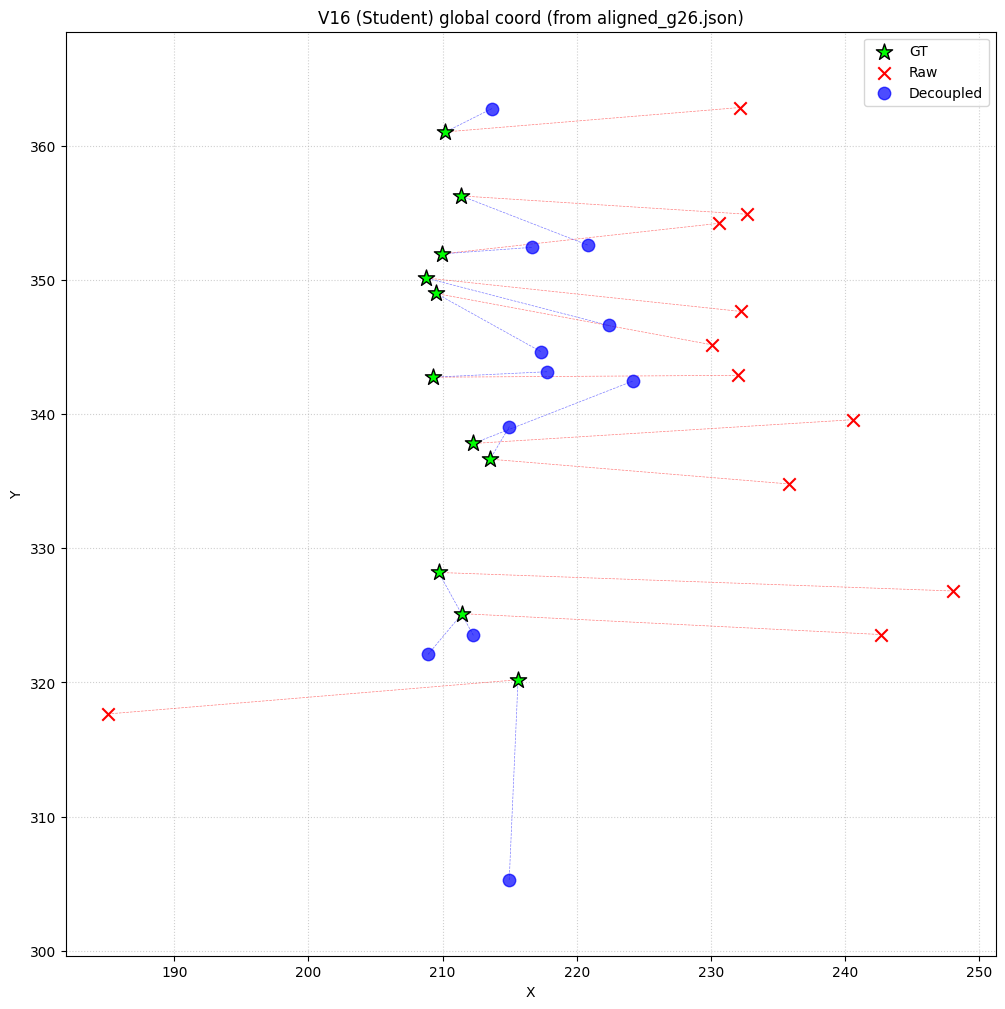

In [32]:
# ---------------------------------
# 步骤 7：自动可视化 (V16 - 学生)
# ---------------------------------
print(f"\n--- 开始可视化 (V16 - 学生模型) ---")
VIZ_MODEL_PATH = STUDENT_MODEL_SAVE_PATH
VIZ_MODEL_TYPE = "Student"
print(f"将加载最佳 {VIZ_MODEL_TYPE} 模型: {VIZ_MODEL_PATH}")

JSON_FILE_PATH_FOR_VIZ = '/work/hwc/SPARSE/training_data/validation_int/aligned_g26.json'
VIZ_PATCH_SIZE = (3, 5)

def load_data_for_viz_v16(json_path, patch_size, device):
    """ 为可视化加载和处理 V16 兼容的数据 """
    raw_patch_list, clean_patch_list, is_odd_list = [], [], []
    peak_coords_18_gt_list, peak_coords_10_merging_list = [], []
    
    if not os.path.isfile(json_path): print(f"错误: 可视化文件未找到: {json_path}"); return [None]*5
    print(f"正在加载并处理可视化文件: {json_path}"); patch_h, patch_w = patch_size; ph, pw = patch_h // 2, patch_w // 2
    pad2d_18_col, pad2d_10_col = (pw, pw, ph, ph), (pw, pw, ph, ph); eps = 1e-8
    
    odd_pairs  = [(0,1),(2,3),(4,5),(6,7),(10,11),(12,13),(14,15),(16,17)]
    odd_map_18_to_10 = {0:0, 1:0, 2:1, 3:1, 4:2, 5:2, 6:3, 7:3, 8:4, 9:5, 10:6, 11:6, 12:7, 13:7, 14:8, 15:8, 16:9, 17:9}
    even_pairs = [(1,2),(3,4),(5,6),(7,8),(9,10),(11,12),(13,14),(15,16)]; even_single= [(0,0), (17,9)]
    even_map_18_to_10 = {0:0, 1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:4, 8:4, 9:5, 10:5, 11:6, 12:6, 13:7, 14:7, 15:8, 16:8, 17:9}
            
    def _compress_to_10_col_viz(matrix_18_col):
        matrix_10_col = np.zeros((32, 10), dtype=np.float32)
        for r in range(32):
            is_odd = (r % 2 == 1); pairs = odd_pairs if is_odd else even_pairs; singles = [(8,4), (9,5)] if is_odd else even_single
            map_18_to_10 = odd_map_18_to_10 if is_odd else even_map_18_to_10
            for (c_left, c_right) in pairs:
                col_10_idx = map_18_to_10[c_left]; avg = (matrix_18_col[r, c_left] + matrix_18_col[r, c_right]) / 2.0; matrix_10_col[r, col_10_idx] = avg
            for (c_18, col_10_idx) in singles: matrix_10_col[r, col_10_idx] = matrix_18_col[r, c_18]
        return matrix_10_col

    try:
        with open(json_path, 'r', encoding='utf-8') as f: aligned_data = json.load(f)
        for point_id, pair_data in aligned_data.items():
            merging_18 = np.array(pair_data['merging']['normalized_matrix'], dtype=np.float32)
            target_18 = np.array(pair_data['nonmerging']['normalized_matrix'], dtype=np.float32)
            if merging_18.shape != (32, 18): continue
            
            peak_r_gt, peak_c_gt_18 = np.unravel_index(np.argmax(target_18), (32, 18))
            target_t_18 = F.pad(torch.from_numpy(target_18), pad2d_18_col)
            r0_t, r1_t = peak_r_gt, peak_r_gt + patch_h
            c0_t, c1_t = peak_c_gt_18, peak_c_gt_18 + patch_w
            clean_patch = target_t_18[r0_t:r1_t, c0_t:c1_t]
            
            effective_merging_10 = _compress_to_10_col_viz(merging_18)
            peak_r_m, peak_c_m_10 = np.unravel_index(np.argmax(effective_merging_10), (32, 10))
            is_odd_m = float(peak_r_m % 2 == 1) 
            merging_t_10 = F.pad(torch.from_numpy(effective_merging_10), pad2d_10_col)
            r0_m, r1_m = peak_r_m, peak_r_m + patch_h
            c0_m, c1_m = peak_c_m_10, peak_c_m_10 + patch_w
            merging_patch = merging_t_10[r0_m:r1_m, c0_m:c1_m]
            
            merging_patch = merging_patch.clamp_min(0); merging_patch = merging_patch / (merging_patch.sum() + eps)
            clean_patch = clean_patch.clamp_min(0); clean_patch = clean_patch / (clean_patch.sum() + eps)
            
            raw_patch_list.append(merging_patch)
            clean_patch_list.append(clean_patch)
            is_odd_list.append(is_odd_m)
            peak_coords_18_gt_list.append([peak_r_gt, peak_c_gt_18])
            peak_coords_10_merging_list.append([peak_r_m, peak_c_m_10])
                
    except Exception as e: print(f"加载 JSON 时出错: {e}"); return [None]*5
    print(f"成功加载 {len(raw_patch_list)} 个可视化样本。")
    
    raw_tensor = torch.stack(raw_patch_list).unsqueeze(1).to(device)
    clean_tensor = torch.stack(clean_patch_list).unsqueeze(1).to(device)
    is_odd_tensor = torch.tensor(is_odd_list, dtype=torch.float32).to(device)
    peak_18_gt_tensor = torch.tensor(peak_coords_18_gt_list, dtype=torch.float32).to(device)
    peak_10_merging_tensor = torch.tensor(peak_coords_10_merging_list, dtype=torch.float32).to(device)
    
    return raw_tensor, clean_tensor, is_odd_tensor, peak_18_gt_tensor, peak_10_merging_tensor

# --- 开始可视化逻辑 ---
try:
    viz_model = StudentModel().to(device) # ⚠️ V16 Student
        
    viz_com_calc_from_10col_patch = CoM_from_Patch_V12(patch_h=VIZ_PATCH_SIZE[0], patch_w=VIZ_PATCH_SIZE[1]).to(device)
    viz_com_calc_from_18col_patch = CoM_from_18col_Patch_V15(patch_h=VIZ_PATCH_SIZE[0], patch_w=VIZ_PATCH_SIZE[1]).to(device)
    
    viz_model.load_state_dict(torch.load(VIZ_MODEL_PATH, map_location=device))
    viz_model.eval()
    print(f"已成功加载最佳 {VIZ_MODEL_TYPE} 模型 {VIZ_MODEL_PATH}")
    
    raw_data, clean_data, is_odd_data, peak_18_gt_data, peak_10_merging_data = load_data_for_viz_v16(
        JSON_FILE_PATH_FOR_VIZ, VIZ_PATCH_SIZE, device
    )

    if raw_data is not None:
        with torch.no_grad():
            clean_global_coords = viz_com_calc_from_18col_patch(clean_data, peak_18_gt_data[:, 0], peak_18_gt_data[:, 1])
            raw_global_coords = viz_com_calc_from_10col_patch(raw_data, is_odd_data, peak_10_merging_data[:, 0], peak_10_merging_data[:, 1])
            pred_patches = viz_model(raw_data, is_odd_data)
            pred_global_coords = viz_com_calc_from_10col_patch(pred_patches, is_odd_data, peak_10_merging_data[:, 0], peak_10_merging_data[:, 1])
            
        raw_coords_np, clean_coords_np, pred_coords_np = raw_global_coords.cpu().numpy(), clean_global_coords.cpu().numpy(), pred_global_coords.cpu().numpy()
        print("全局坐标计算完毕。")

        def transform_coords(coords_np):
            x, y = coords_np[:, 0] * 64.0 + 32.0, coords_np[:, 1] * 64.0 + 32.0
            return x, y
        raw_x_viz, raw_y_viz = transform_coords(raw_coords_np)
        clean_x_viz, clean_y_viz = transform_coords(clean_coords_np)
        pred_x_viz, pred_y_viz = transform_coords(pred_coords_np)

        print("开始绘图..."); plt.figure(figsize=(12, 12))
        plt.scatter(clean_x_viz, clean_y_viz, marker='*', s=150, c='lime', edgecolors='black', label='GT', zorder=5)
        plt.scatter(raw_x_viz, raw_y_viz, marker='x', s=80, c='red', label='Raw', zorder=4)
        plt.scatter(pred_x_viz, pred_y_viz, marker='o', s=80, c='blue', alpha=0.7, label=f'Decoupled', zorder=3)
        for i in range(len(clean_x_viz)):
            plt.plot([raw_x_viz[i], clean_x_viz[i]], [raw_y_viz[i], clean_y_viz[i]], 'r--', linewidth=0.5, alpha=0.5)
            plt.plot([pred_x_viz[i], clean_x_viz[i]], [pred_y_viz[i], clean_y_viz[i]], 'b--', linewidth=0.5, alpha=0.5)
        plt.title(f"V16 ({VIZ_MODEL_TYPE}) global coord (from {os.path.basename(JSON_FILE_PATH_FOR_VIZ)})"); plt.xlabel("X")
        plt.ylabel("Y"); plt.legend(); plt.grid(True, linestyle=':', alpha=0.6); plt.axis('equal'); plt.show()
    else: print("可视化数据未加载，无法执行绘图。")
except Exception as e:
    print(f"\n--- ⚠️ 可视化失败! ⚠️ ---"); print(f"错误: {e}"); print(f"请确保 {VIZ_MODEL_PATH} 和 {JSON_FILE_PATH_FOR_VIZ} 路径正确。")